## Pretrained fasttext model on Urban Dictionary

In [1]:
# Importing libraries
import gensim
# import gensim.downloader
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import numpy as np
import os
from statistics import mean
import pandas as pd 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
# from IPython.display import Image
from IPython.display import display
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from matplotlib.axes._axes import _log as matplotlib_axes_logger
# matplotlib_axes_logger.setLevel('ERROR')
%matplotlib inline

In [2]:
# import nltk
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Constants

In [2]:
TOP_N = 30
KEYS = { \
    "offensive": set(), 
    "abusive": set(), 
    "cyberbullying": set(), 
    "vulgar": set(), 
    "racist": set(), 
    "homophobic": set(), 
    "profane": set(), 
    "slur": set(), 
    "harrasment": set(), 
    "obscene": set(), 
    "threat": set(), 
    "discredit": set(), 
    "hateful": set(), 
    "insult": set(), 
    "hostile": set()
}
FIXED_KEYS = list(KEYS.keys())

Too similar words that will not be taken into account as neighbouring words:

In [3]:
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'offensive': {'offens', 'offensive'},
 'abusive': {'abus', 'abusive'},
 'cyberbullying': {'cyberbulli', 'cyberbullying'},
 'vulgar': {'vulgar'},
 'racist': {'racist'},
 'homophobic': {'homophob', 'homophobic'},
 'profane': {'profan', 'profane'},
 'slur': {'slur'},
 'harrasment': {'harras', 'harrasment'},
 'obscene': {'obscen', 'obscene'},
 'threat': {'threat'},
 'discredit': {'discredit'},
 'hateful': {'hate', 'hateful'},
 'insult': {'insult'},
 'hostile': {'hostil', 'hostile'}}

### Functions

In [4]:
def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
        
    return False

In [5]:
def get_similar_words(model_gn):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in model_gn.most_similar(key, topn=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(model_gn[similar_word])
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [6]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)

In [7]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [8]:
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [9]:
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [10]:
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

## fastText model

We first set the path to our pretrained model:

In [11]:
cd C:\Users\User\Downloads

C:\Users\User\Downloads


### Loading basic model (usual tokenization, no guidance on how to utilize phrases)

In [13]:
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('C:\\Users\\User\\Downloads\\ud_basic.vec')

Getting similar words. Printed out words are neighboring words that are ommited for the analysis.

In [14]:
word_clusters, embedding_clusters = getSimilarWords(model)

{'offens', 'offensive'} -- offensively
{'offens', 'offensive'} -- inoffensive
{'offens', 'offensive'} -- offension
{'offens', 'offensive'} -- offensitive
{'offens', 'offensive'} -- offense
{'offens', 'offensive'} -- counter offensive
{'offens', 'offensive'} -- inoffensively
{'abusive', 'abus'} -- abuse
{'abusive', 'abus'} -- abuses
{'abusive', 'abus'} -- abusing
{'abusive', 'abus'} -- abusage
{'cyberbullying', 'cyberbulli'} -- cyberbullied
{'vulgar'} -- vulgarity
{'vulgar'} -- vulgarness
{'vulgar'} -- vulgarism
{'racist'} -- racists
{'racist'} -- racistism
{'racist'} -- racistist
{'racist'} -- semi racist
{'racist'} -- ignoracist
{'racist'} -- embracist
{'racist'} -- racister
{'racist'} -- biracist
{'racist'} -- anti racist
{'racist'} -- half racist
{'racist'} -- tracist
{'racist'} -- racistic
{'racist'} -- i'm not racist but
{'homophobic', 'homophob'} -- homophobe
{'homophobic', 'homophob'} -- homophobephobe
{'homophobic', 'homophob'} -- homophobophobe
{'homophobic', 'homophob'} -- ho

In [15]:
displayDF(word_clusters)

,offensive,abusive,cyberbullying,vulgar,racist,homophobic,profane,slur,harrasment,obscene,threat,discredit,hateful,insult,hostile
0,insulting,amusive,cyberhickery,profane,racism,homofobe,vulgar,racial,harassment,vulgar,thromise,undermine,unnasty,derogatory,squabbly
1,vulgar,attackitive,facebookmurderous,offensive,sexist,queerphobic,inappropriation,derogatory,msnexual,profane,dtra,demonize,spiteful,hunkybuckler,aggressive
2,ofensive,abooze,bullying,obscene,urbadejudice,boopler,obscene,nigletarian,soulja55,inappropriate,humanicide,delegitimize,slooce,isult,aggrovated
3,derogatory,mysogynistic,facebully,dumbflip,racititism,heterophobes,cursewords,euromutt,freemaned,profanity,jojanie,despouch,bigoted,bitchkid,gasolinism
4,shisnu,kiwi_m8,googlecide,crude,arkun,racist,cropweasel,coondoo,nosessual,obscane,mckaye,belittle,disrespectul,comeback,incursive
5,motherflipping,manipulative,willowsgrim,profanity,bigoted,fauxmophobe,offensive,pejorative,pinne,inappropriation,rrdd,swift-boat,attackitive,nipet,militarize
6,buttrat,fashus,cyberdickery,crooperdooper,negrophobe,homosexism,fadoogal,racist,flagiggle,offensive,preat,mischaracterize,uncharitable,complidis,unfriendly
7,dumbflip,faly,jdsonic,inappropriation,homophobic,campophobia,roniky,ashleg,harasment,crude,ostracization,perjure,itawamba,cuntoris,aggroculture
8,disparaging,controlfreak,cyberstalking,cropweasel,nigletarian,sexist,spurnacular,weagian,mexual,crappology,peachkick,invalidate,mysogynistic,gafoogan,kaberagore
9,profane,stepparent,bullycide,errikupa,xenist,straightophobe,swearing,bollywog,eve-teasing,obsene,youbee,revilement,dissentomatic,mowhead,fighty


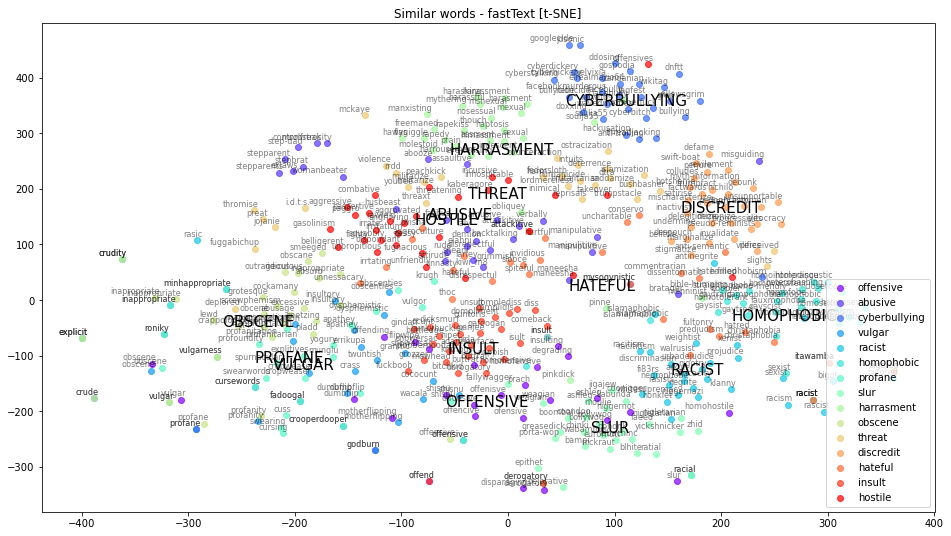

In [16]:
plotTSNE("Similar words - fastText [t-SNE]", word_clusters, embedding_clusters, "SimilarWords - fastText - t-SNE.png")

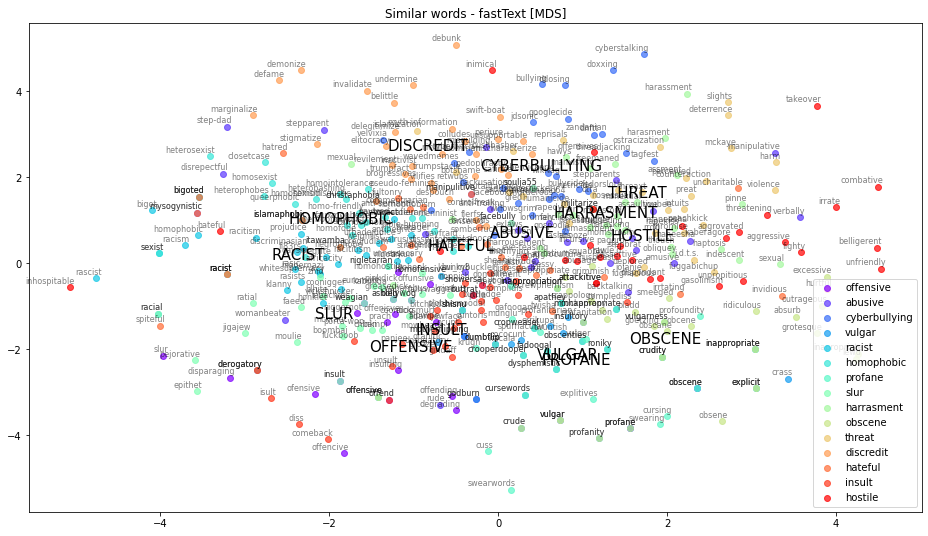

In [17]:
plotMDS("Similar words - fastText [MDS]", word_clusters, embedding_clusters, "SimilarWords - fastText - MDS.png")

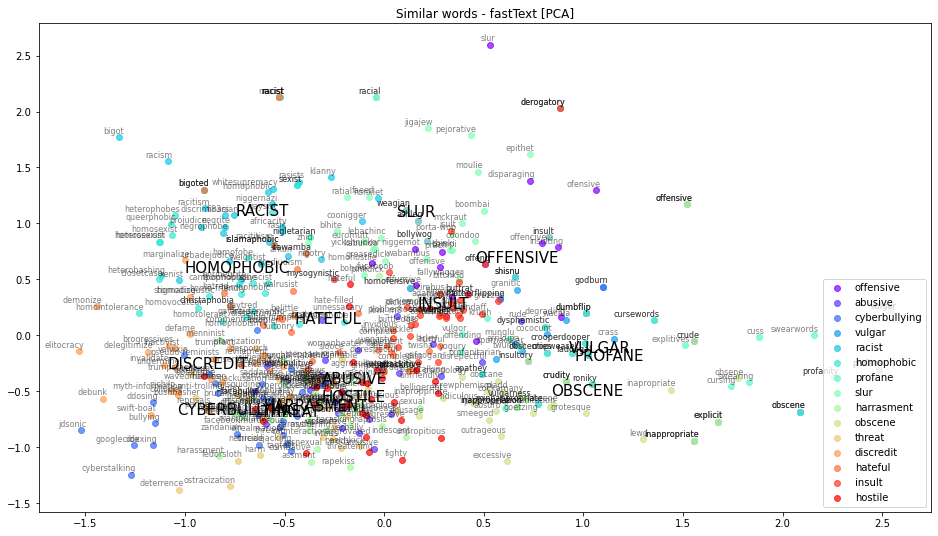

In [18]:
plotPCA("Similar words - fastText [PCA]", word_clusters, embedding_clusters, "SimilarWords - fastText - PCA.png")

### Loading model which utilizes the vast list of phrases in Urban Dictionary

In [12]:
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('C:\\Users\\User\\Downloads\\ud_phrase.vec')

In [13]:
word_clusters, embedding_clusters = getSimilarWords(model)

{'offensive', 'offens'} -- inoffensive
{'offensive', 'offens'} -- offensively
{'offensive', 'offens'} -- nonoffensive
{'offensive', 'offens'} -- inoffensively
{'offensive', 'offens'} -- offense
{'offensive', 'offens'} -- offension
{'offensive', 'offens'} -- counter offensive
{'offensive', 'offens'} -- racially offensive
{'abusive', 'abus'} -- abuse
{'abusive', 'abus'} -- abuses
{'abusive', 'abus'} -- emotional abuse
{'abusive', 'abus'} -- abuser
{'abusive', 'abus'} -- abusive cunt
{'abusive', 'abus'} -- abused
{'abusive', 'abus'} -- abusing
{'abusive', 'abus'} -- abusee
{'cyberbulli', 'cyberbullying'} -- cyberbullied
{'cyberbulli', 'cyberbullying'} -- cyberbullies
{'vulgar'} -- vulgarity
{'racist'} -- a racist
{'racist'} -- racists
{'racist'} -- racistism
{'racist'} -- racistic
{'racist'} -- hipster racist
{'racist'} -- self racist
{'racist'} -- semi racist
{'racist'} -- racist cracker asshole
{'racist'} -- not racist
{'racist'} -- embracist
{'racist'} -- racist black person
{'racist'}

In [14]:
displayDF(word_clusters)

,offensive,abusive,cyberbullying,vulgar,racist,homophobic,profane,slur,harrasment,obscene,threat,discredit,hateful,insult,hostile
0,insulting,amusive,cyber_bullying,profane,racism,queerphobic,vulgar,yats_dionarap,msnexual_harassment,inappropriation,thromise,delegitimize,slooce,comeback,squabbly
1,vulgar,stepparent,cyberhickery,offensive,sexist,homosexism,crudity,derogatory,assualts,vulgar,bethel_park_high_school,undermine,unnasty,ninja_compliment,aggressive
2,offesnive,fashus,facebookmurderous,crude,africacity,fauxmophobe,what_the_cuss,spa_gook,haptosis,obsene,preemptive_revenge,despouch,disrespectul,isult,unfriendly
3,derogatory,attackitive,bullying,godburn,gradexist,racist,salty_language,salthead,menstrual_assault,inappropriate,youbee,intellectually_honest,spiteful,derogatory,angressive
4,flyingflip,manipulative,bullycide,motherflipping,kkkramer,homofobe,cursewords,pickle_dragon,street_harassment,profane,preat,swift-boat,anti-semitic,mowhead,inhospitable
5,competitively_racist,kiwi_m8,cyber_suicide,dumbflip,rasists,sexist,obscene,carpet_snail,harasment,crudity,twade_smash,perjure,competitively_racist,nipet,salty_bullshit
6,taco_people,stepbrat,msnexual_harassment,obscene,racial_racism,homosexist,australian_tailgate,racial,harassment,obscane,wifepoint,revilement,attackitive,diss,paggro
7,sense_offender,precious_little_snowflake,facebully,flyingflip,urbadejudice,gaysist,dumbflip,slumble,harassments,vulgarity,your_days_are_numbered,false_angel,vitriolic,ocunt,fugnacious
8,offenisve,parental_alienation,google_rape,crap_biscuit,racitism,boopler,crooperdooper,ashleg,eve-teasing,pladd,school_lockdown,defame,bigoted,complidis,gasolinism
9,motherflipping,ex_from_hell,jdsonic,coarse_language,arkun,homo-friendly,filthy_smut,night_skin,inverse_rape,crappology,dtra,racial_coercion,fultonry,shizz_biscuit,passive_assertive


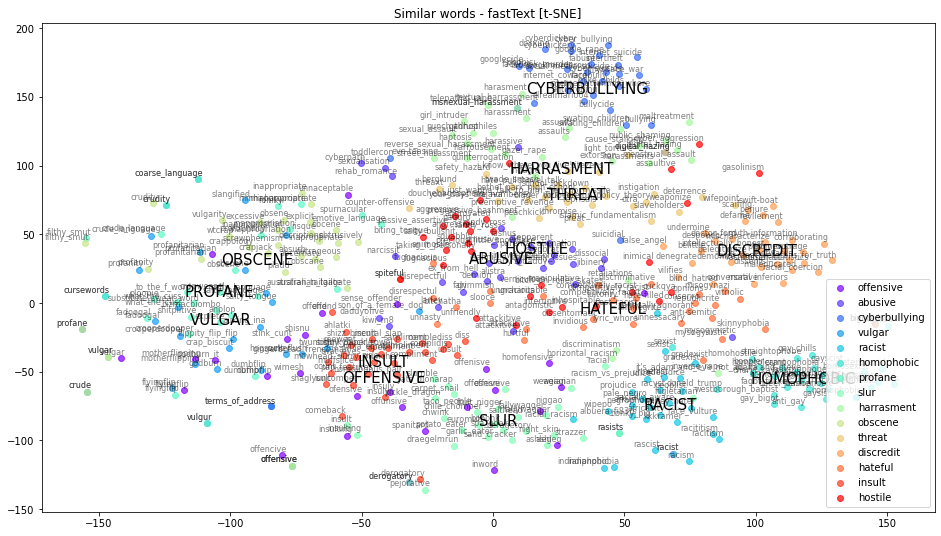

In [16]:
plotTSNE("Similar words - fastText [t-SNE]", word_clusters, embedding_clusters)

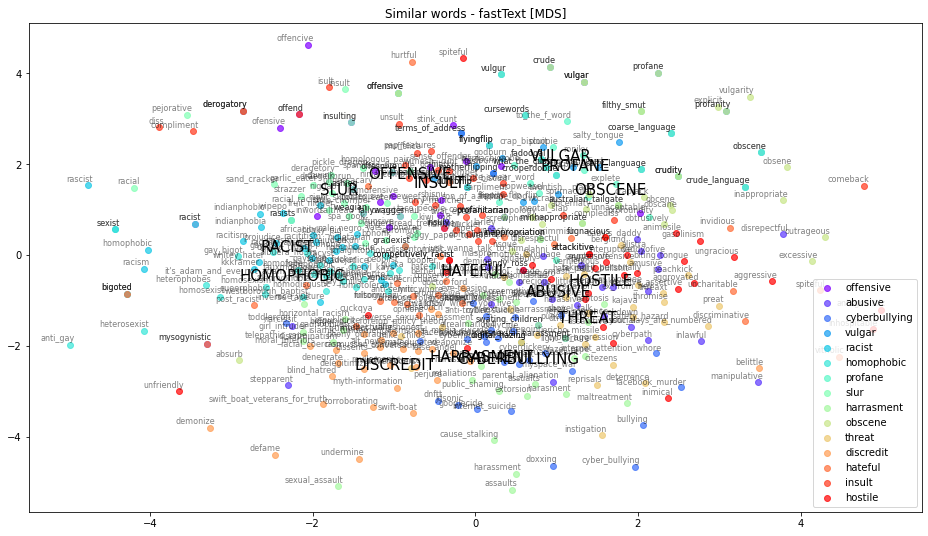

In [17]:
plotMDS("Similar words - fastText [MDS]", word_clusters, embedding_clusters)

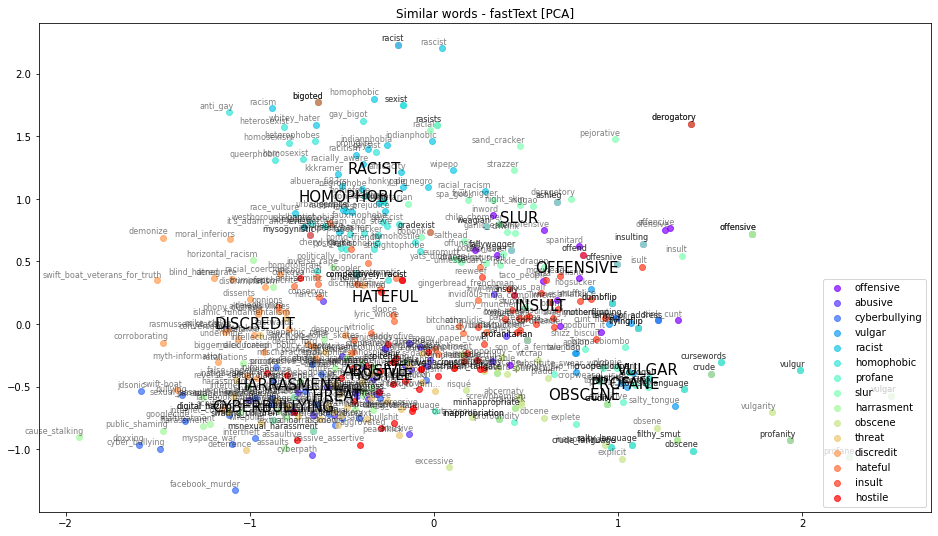

In [18]:
plotPCA("Similar words - fastText [PCA]", word_clusters, embedding_clusters)